<a href="https://colab.research.google.com/github/jularch/compling/blob/main/%D0%94%D0%97_%E2%84%963_%22SMT_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SMT**

 **Принцип работы**

на основе **данного** предложения создаёт:
1. сначала его языковую модель,
2. затем с помощью параллельного корпуса сопоставляет статистические совпадения фраз (т.е по средствам статистических данных выявляет наиболее похожие пары),
3. максимизирует резултаты вычисления (оставляет максимально точные резульаты)

**Компоненты**
1. *N-граммная языковая модель* - моделирует вероятностное распределение конструкций на уровне слов или фраз в языке Y
2. *Модель перевода (t-model)* - собирает статистику соотвествий фраз в паралелльном корпусе, ищет переводческие соответствия X - Y и моделируем их с помощью теории вероятности.

 **Допускаем, что любое предложение языка Y может быть "искаженной" версией некой фразы на языке X**

 **Ищем наиболее правдоподобные соответствия X - Y**
3. *Декодер* - ищет наиболее грамматичные и лексически правдоподобные результаты, отбирает среди гипотез один результат.

**Параллельные корпуса**
* OP[Текст ссылки](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fopus.nlpl.eu%2F)US Corpora (открытый параллельный корпус)
* [Kaggle](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Fdevicharith%2Flanguage-translation-englishfrench)
* [HuggingFace](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fhuggingface.co%2Fdatasets%3Ftask_categories%3Dtask_categories%3Atranslation%26sort%3Dtrending)
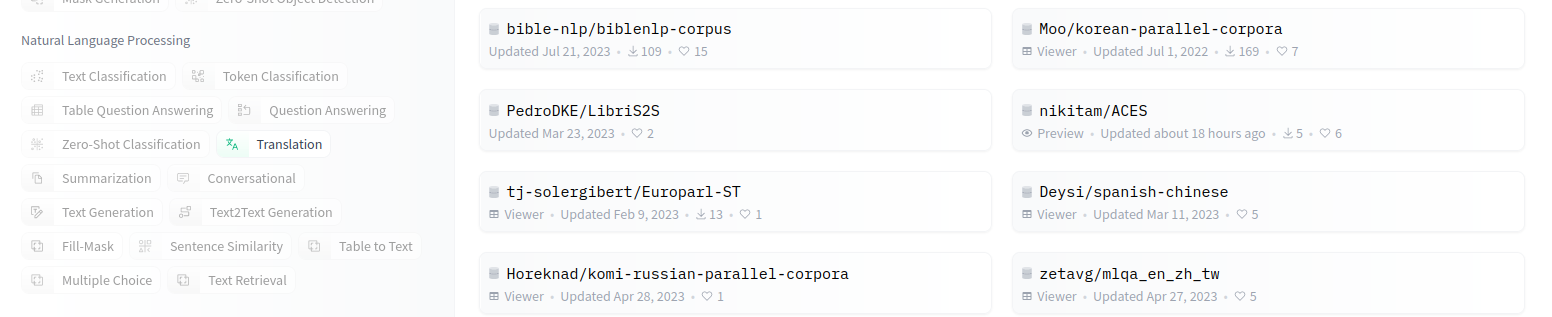
**Библиотеки**: sklearn

In [ ]:
import tarfile

from sklearn.model_selection import train_test_split

from collections import Counter, defaultdict
import random

# **Модель** *IBM 1 Expectation-Maximization (t-model)*

In [ ]:
# вероятность того, что случайное слово x_vocab соответсвует случайному слову y_vocab
uniform = 1 / (len(x_vocab) * len(y_vocab))

round(uniform, 3)

In [ ]:
# t-model
t = {}

for i in range(len(X_train)):
  # начинаем итерацию по обучающей выборке
  for word_x in X_train_tokens[i]:
    for word_y in y_train_tokens[i]:
      # создаем t-table
      t[(word_x, word_y)] = uniform

# t-table
for elem in t:
  print("Соответствие |", elem[0], "  ->  ", elem[1], "| Вероятность:", round(t[elem], 3))

In [ ]:
# количество итераций обучения
epochs = 7

In [ ]:
for epoch in range(epochs):
  # начинаем обучение

  # шаг 0. создаем слоты для подсчета статистики
  count = {} # P(x|y)
  total = {} # P(y)

  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # создаем слоты для подсчета условной вероятности совпадений в корпусе
        count[(word_x, word_y)] = 0
        # и слоты для статистической языковой модели y
        total[word_y] = 0

  # шаг 1. Expectation
  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    total_stat = {} # статистика x

    # собираем предварительную статистику на основе данных x
    for word_x in X_train_tokens[i]:
      total_stat[word_x] = 0 # создаем слоты для подсчета статистики по каждому токену x
      for word_y in y_train_tokens[i]:
        # обновляем данные из t-table; увеличиваем значения при обнаружении совместной встречаемости
        total_stat[word_x] += t[(word_x, word_y)]

    # обновляем данные для P(x|y) и P(y)
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # подсчет условной вероятности совпадений в корпусе: равномерное распределение / частотность x
        count[(word_x, word_y)] += t[(word_x, word_y)] / total_stat[word_x]
        # подсчет статистической информации y: равномерное распределение / частотность x
        total[word_y] += t[(word_x, word_y)] / total_stat[word_x]

  # шаг 2. Maximization
  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # обновляем t-table: вероятность совпадения в корпусе / вероятность информации y
        t[(word_x, word_y)] = count[(word_x, word_y)] / total[word_y]

for elem in t:
  print("Соответствие |", elem[0], "  ->  ", elem[1], "| Вероятность:", round(t[elem], 3))

# **Биграммная модель**

In [ ]:
# для обучения модели объединим 2 выборки
tokens = ' '.join(german).split()

# хранилище для биграмм
bigram_model = defaultdict(list)

# собираем все попарные совпадения
for i in range(len(tokens)-1):
    current_word = tokens[i]
    next_word = tokens[i + 1]
    bigram_model[current_word].append(next_word)

print(bigram_model)

def decoder(model, steps=5):
  # инициализация случайного токена
  current_word = random.choice(tokens)
  generated_sentence = current_word

  for step in range(steps):
    # пошаговая генерация
    print('Шаг', step+1)
    next_word_options = model[current_word]
    print(f'Правдоподобные варианты продолжения для токена {current_word}:', next_word_options)

    current_word = random.choice(next_word_options)
    generated_sentence += ' '
    generated_sentence += current_word
    print('Промежуточный результат:', generated_sentence)
    print()
  print('Результат:', generated_sentence)

decoder(bigram_model)

# **Оценка результатов** - через [NLK Translate](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.nltk.org%2Fapi%2Fnltk.translate.bleu_score.html)

In [ ]:
# сортировка t-table по убыванию правдоподобия
sorted_t = sorted(t.items(), key = lambda k:(k[1], k[0]), reverse = True)

def translate(token):
  for element in sorted_t:
    if element[0][1] == token:
      # поиск совпадений в t-table
      return element[0][0]

for sentence in y_test_tokens:
  print("Оригинальное предложение:", ' '.join(sentence))
  translation = []
  for token in sentence:
    translation.append(translate(token))
  print("Перевод:", ' '.join(translation))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

reference = [X_test_tokens[0], X_test_tokens[1]]
candidate = [translate(token) for token in y_test_tokens[0]]

bleu_score = corpus_bleu(reference, candidate)

print("BLEU Score:", bleu_score)

In [ ]:
reference

In [ ]:
candidate

# ***Полезные коды***

*Создаем выборки и токенизируем тексты по фразам.*

In [ ]:
with open('toy.de', 'r') as f:
  german = f.read().split('\n')[:-1]

with open('toy.en', 'r') as f:
  english = f.read().split('\n')[:-1]

print("Данные языка X:\n", german)
print("Данные языка Y:\n", english)

*Разделим выборкe с помощью sklearn.*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(english, german)

print("> Обучающая выборка:")
for text, label in zip(X_train, y_train):
    print(f"\nТекст на немецком: {label}\n Его перевод на английский: {text}\n")

print("> Тестовая выборка:")
for text, label in zip(X_test, y_test):
    print(f"\nТекст на немецком: {label}\n Его перевод на английский: {text}\n")

# Подготовка данных

*Пословная токенизация*

In [ ]:
def tokenize(sentences):
  # функция возвращает списки слов
  return [sentence.split() for sentence in sentences]

# токенизируем каждую выборку
X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens = tokenize(X_train), tokenize(X_test), tokenize(y_train), tokenize(y_test)

print('Образец токенизированного текста:', X_train_tokens)

*Словарь словоформ*

In [ ]:
x_vocab = Counter(' '.join(german).split()).keys()
y_vocab = Counter(' '.join(english).split()).keys()

print(f"Словарь немецких словоформ: {x_vocab}\n Всего {len(x_vocab)} словоформ")
print(f"\nCловарь английских словоформ: {y_vocab}\n Всего {len(y_vocab)} словоформ")